In [2]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from surprise import Dataset, NormalPredictor, Reader, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
import textacy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import stellargraph as sg
import tensorflow as tf
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph import datasets
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from scipy import stats
from sklearn.metrics import roc_curve, auc
from random import sample

In [7]:
df0 = pd.read_csv("Data/cancer_dataset.csv", encoding='latin1', index_col=0)
df = df0["a"]

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df0['0'])
set(labels)

{0, 1, 2}

In [8]:
with open("Data/topics_clf.pickle", "rb") as f:
    topics = pkl.load(f)
topics = np.array(topics)

In [9]:
max(topics)

278

In [10]:
#

In [11]:
ratings_dict = {
    "itemID": np.array(df),
    "userID": topics,
    "rating": labels,
}
df_recommender = pd.DataFrame(ratings_dict)
df_recommender

,itemID,userID,rating
0,Thyroid surgery in children in a single insti...,168,2
1,""" The adopted strategy was the same as that us...",221,2
2,coronary arterybypass grafting thrombosis ï¬b...,97,2
3,Solitary plasmacytoma SP of the skull is an u...,95,2
4,This study aimed to investigate serum matrix ...,239,2
...,...,...,...
7565,we report the case of a 24yearold man who pres...,26,0
7566,among synchronous colorectal cancers scrcs rep...,160,0
7567,the heterogeneity of cancer cells is generally...,59,0
7568,"""adipogenesis is the process through which mes...",107,0


In [12]:
reader = Reader(rating_scale=(0, 2))
data = Dataset.load_from_df(df_recommender[["userID", "itemID", "rating"]], reader)

In [13]:
algo = SVD()
cross_validate(algo, data, cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1275  0.1177  0.1121  0.1251  0.1154  0.1196  0.0058  
MAE (testset)     0.0840  0.0817  0.0767  0.0827  0.0791  0.0808  0.0026  
Fit time          0.04    0.02    0.03    0.03    0.02    0.03    0.01    
Test time         0.01    0.00    0.00    0.02    0.02    0.01    0.01    


In [14]:
algo.fit(data.build_full_trainset())

In [15]:
a = np.array(data.raw_ratings)
a[:, 2]

array([2.0, 2.0, 2.0, ..., 0.0, 0.0, 0.0], dtype=object)

In [16]:
uid = str(np.array(data.raw_ratings)[:, 0][7569])
iid = str(np.array(data.raw_ratings)[:, 1][7569])#str(26)

pred = algo.predict(uid, iid, r_ui=None)
print(pred.est)

0.7988558717237826


In [17]:
y_pred = []
for i in range(len(df_recommender)):
    uid = str(np.array(data.raw_ratings)[:, 0][i])
    iid = str(np.array(data.raw_ratings)[:, 1][i])
    y = algo.predict(uid, iid, r_ui=np.array(data.raw_ratings)[:, 2][i])
    y_pred.append(y.est)

In [17]:
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

def map_to_discrete(normalized_value):
    if normalized_value < 1/3:
        return 0
    elif normalized_value < 2/3:
        return 1
    else:
        return 2

In [18]:
min_val, max_val = min(y_pred), max(y_pred)

In [19]:
y_pred0 = []
for i in range(len(df_recommender)):
    uid = str(np.array(data.raw_ratings)[:, 0][i])
    iid = str(np.array(data.raw_ratings)[:, 1][i])
    y = algo.predict(uid, iid, r_ui=np.array(data.raw_ratings)[:, 2][i])
    
    normalized_value = normalize(y.est, min_val, max_val)
    discrete_value = map_to_discrete(normalized_value)
    
    y_pred0.append(discrete_value)

In [20]:
accuracy_score(y_pred0, labels)

0.9519154557463673

In [21]:
with open('Data/recommender_preds.pickle', 'wb') as f:
    pkl.dump(y_pred0, f)
    
with open("Data/recommender_preds.pickle", "rb") as f:
    y_pred1 = pkl.load(f)

In [22]:
#

In [23]:
with open("Data/graphs.pkl", "rb") as f:
    Gs = pkl.load(f)
GG = nx.disjoint_union_all(Gs)

In [24]:
with open("Data/combined_graphed.pkl", "rb") as f:
    node_vectors_list_cmb = pkl.load(f)

with open("Data/individual_graphed.pkl", "rb") as f:
    node_vectors_list_ind = pkl.load(f)

In [25]:
word_dict = {}
i = 0
for G in Gs:
    for node in list(G.nodes):
        word_dict[i] = node
        i += 1

In [26]:
len_each_graph = [len(i) for i in node_vectors_list_ind]
print(len_each_graph[:20])

[88, 76, 91, 90, 117, 125, 94, 106, 188, 203, 182, 170, 167, 183, 203, 45, 144, 185, 182, 161]


In [27]:
vec_list = np.array(node_vectors_list_cmb[0])
len(vec_list)

1009270

In [28]:
labels_extended = []
for i, l in enumerate(len_each_graph):
    labels_extended.extend([labels[i]]*l)
X_train, X_test, y_train, y_test = train_test_split(
    vec_list, labels_extended, test_size=0.1
)
#model = LinearSVC()
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [29]:
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.48206129182478424
F1 Score: 0.5303857556757521


In [30]:
y_pred = model.predict(vec_list)

In [31]:
#

In [36]:
inconsistent_words = []
for i in differences_index:
    inconsistent_words.append(word_dict[i])

In [ ]:
import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=50, max_font_size=45)
wc = wc.generate('_'.join(inconsistent_words).replace('_', ' '))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [25]:
#

In [33]:
topics_extended = []
for i, l in enumerate(len_each_graph):
    topics_extended.extend([y_pred0[i]]*l)

In [34]:
len(topics_extended)

1009270

In [122]:
differences_index = []
for i, l in enumerate(y_pred):
    if l != topics_extended[i]:
        differences_index.append(i)
len(differences_index)

566347

In [124]:
alpha = 0.7
differences_index = sample(differences_index, round(len(differences_index)*alpha))

In [125]:
vec_list_reduced = np.delete(vec_list, differences_index, axis=0)
bert_reduced = np.delete(topics_extended, differences_index)
labels_extended_reduced = np.delete(labels_extended, differences_index)

In [126]:
len_each_graph_new = np.array(len_each_graph.copy())
cumsum_len_each_graph = np.cumsum(len_each_graph)

decrements = np.zeros_like(len_each_graph_new)

indices = np.digitize(differences_index, cumsum_len_each_graph)

np.add.at(decrements, indices, -1)

len_each_graph_new += decrements


In [131]:
len(len_each_graph_new[len_each_graph_new==0]), len(len_each_graph), len(differences_index)

(3, 7570, 396443)

In [128]:
#len_each_graph_new = len_each_graph.copy()
#cumsum_len_each_graph = np.cumsum(len_each_graph)
#for i in differences_index:
#    if i<cumsum_len_each_graph[0]:
#        len_each_graph_new[0] -= 1
#    else:
#       for j in range(0, len(len_each_graph)-1):
#            if i>=cumsum_len_each_graph[j] and i<cumsum_len_each_graph[j+1]:
#                len_each_graph_new[j+1] -= 1

In [129]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    vec_list_reduced, labels_extended_reduced, test_size=0.3
)
#model_r = LinearSVC()
model_r = GaussianNB()
model_r.fit(X_train_r, y_train_r)

GaussianNB()

In [130]:
y_pred_r = model_r.predict(X_test_r)
accuray = accuracy_score(y_pred_r, y_test_r)
f1 = f1_score(y_pred_r, y_test_r, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.7166370227741244
F1 Score: 0.7403373322124387


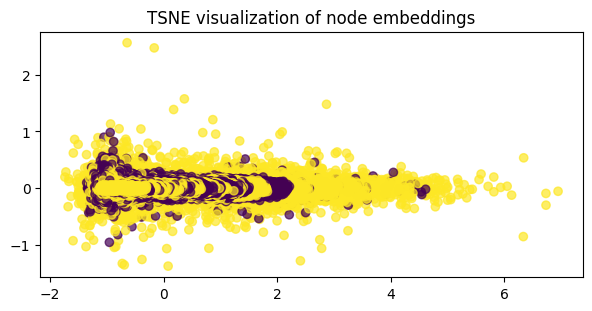

In [97]:
colors = np.ones(len(vec_list))
colors[differences_index] = 0

transform = TSNE  # PCA

trans = PCA(n_components=2)
node_embeddings_2d = trans.fit_transform(vec_list)
alpha = 0.7

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=colors,
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [1]:
# remove top alpha percents of the inconsistent data and not only random

In [62]:
# t-test

In [98]:
res_accuracy = []
res_f1 = []
for i in range(30):
    deleted_indices = np.random.randint(len(vec_list), size=len(differences_index))
    #vec_list_reduced = np.array([l for i, l in enumerate(vec_list) if i not in deleted_indices])
    vec_list_reduced = np.delete(vec_list, deleted_indices, axis=0)
    labels_extended_reduced = np.delete(labels_extended, deleted_indices)
    
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        vec_list_reduced, labels_extended_reduced, test_size=0.3
    )
    
    model_r = GaussianNB()
    model_r.fit(X_train_r, y_train_r)
    
    y_pred_r = model_r.predict(X_test_r)
    accuray = accuracy_score(y_pred_r, y_test_r)
    f1 = f1_score(y_pred_r, y_test_r, average="weighted")
    
    res_accuracy.append(accuray)
    res_f1.append(f1)

In [99]:
t_stat_accuracy, p_value_accuracy = stats.ttest_1samp(res_accuracy, 0.57)
t_stat_f1, p_value_f1 = stats.ttest_1samp(res_f1, 0.58)
print("T statistic for accuracy:", t_stat_accuracy)
print("P-value for accuracy:", p_value_accuracy)
print("T statistic for f1:", t_stat_f1)
print("P-value for f1:", p_value_f1)

# Setting significance level
alpha = 0.05

if p_value_accuracy < alpha and p_value_f1 < alpha:
    print("Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean.")

T statistic for accuracy: -435.54780980029426
P-value for accuracy: 6.899190169965849e-57
T statistic for f1: -264.7846025525378
P-value for f1: 1.274557919518201e-50
Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean.
